# **Exploring Feature Importance with MMoCHi**

**Authors:** Daniel Caron and William Specht 

**In this notebook, we will evaluate individual features for their importance during random forest classification. This can provide insight into how the random forests are performing and identify novel transcriptomic and proteomic markers of cell subsets.**
    
## **Exploring Feature importances**
    
#### What are feature importances and why use them?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Unlike some supervised classifiers, which rely on strict feature selection or dimensionally reduced feature sets, random forests perform well with high-dimensional data. When training decision trees, features are selected for their ability to reduce impurity at each branch. To reduce overfitting, random forests average over multiple decision trees trained under similar conditions. This naturally lends itself well to ranking features based on their importance for classification. Although there are many methods to calculate feature importance, here we use scikit-learn's implementation of [impurity-based feature_importances](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) where importance is calculated from the mean decrease in Gini impurity across the trees in a forest. A ranking of these importances can then be generated for each classification layer providing insight into differences between subsets at each level of the classifier. Note that [other methods](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) to calculate important features, including permutation-based methods, tend to be much slower to calculate, but could also be used.
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Feature importances can serve a few purposes. First, they can be used to understand how the random forest is classifying cell types and may reveal why specific events are or are not being labeled correctly. While well-performing classifiers will have high feature importances for highly expressed cell type markers, poorly performing classifiers may give high feature importance to batch-specific artifacts. If this is the case, the training data or feature set given to the random forest for classification can be altered to improve performance. Alternatively, if cell type markers are given a high performance but classification is still sub-par, random forest hyperparameters (with the `clf_kwargs` argument in `mmc.Hierarchy.add_classification()`) can be altered to increase fit and improve performance. More information on random forest hyperparameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Another useful application of feature importances is as a discovery tool for novel cell type markers. Newly identified markers may inform high confidence thresholding and fluorescence-based gating strategies. For this application, it's worth noting that feature importances are not associated with individual subsets, so one must take care during interpretation of highly important features, especially in multiclass scenarios. To associate features with a subset, we suggest using other metrics, such as high log-fold enrichment or change in dropout rate. By providing a window into profiles of our cell types, features identified may also pave the way for new avenues of study, similar to differential expression. See our preprint for more details.

## **Import packages**

In [1]:
import anndata
import mmochi as mmc
mmc.log_to_file('data/mmochi_feature_importance')

## **Load in hierarchy used for classification and classified data**

<div class="alert alert-danger">
    
**Run Integrated Classification First!**
    
This tutorial builds off of the [Integrated Classification tutorial](./Integrated_Classification.ipynb), and uses the trained MMoCHi classifier and classified AnnData object saved during that tutorial.
</div>

Let's load the previously saved AnnData and MMoCHi Hierarchy objects in:

In [2]:
adata = anndata.read_h5ad('data/classified_events.h5ad') 
adata

AnnData object with n_obs × n_vars = 13112 × 33538
    obs: 'batch', 'leiden', 'T_B doublets', 'classification', 'conf'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Broad Lineages_proba', 'CD4_CD8_proba', 'Lymphoid_proba', 'NK_ILC Subsets_proba', 'batch_colors', 'landmark_protein_peaks', 'leiden_colors', 'protein_peaks'
    obsm: 'X_umap', 'landmark_protein', 'lin', 'protein', 'protein_counts'
    layers: 'counts'

Loading classifier from data/IntegratedClassifier...


Loaded data/IntegratedClassifier.hierarchy


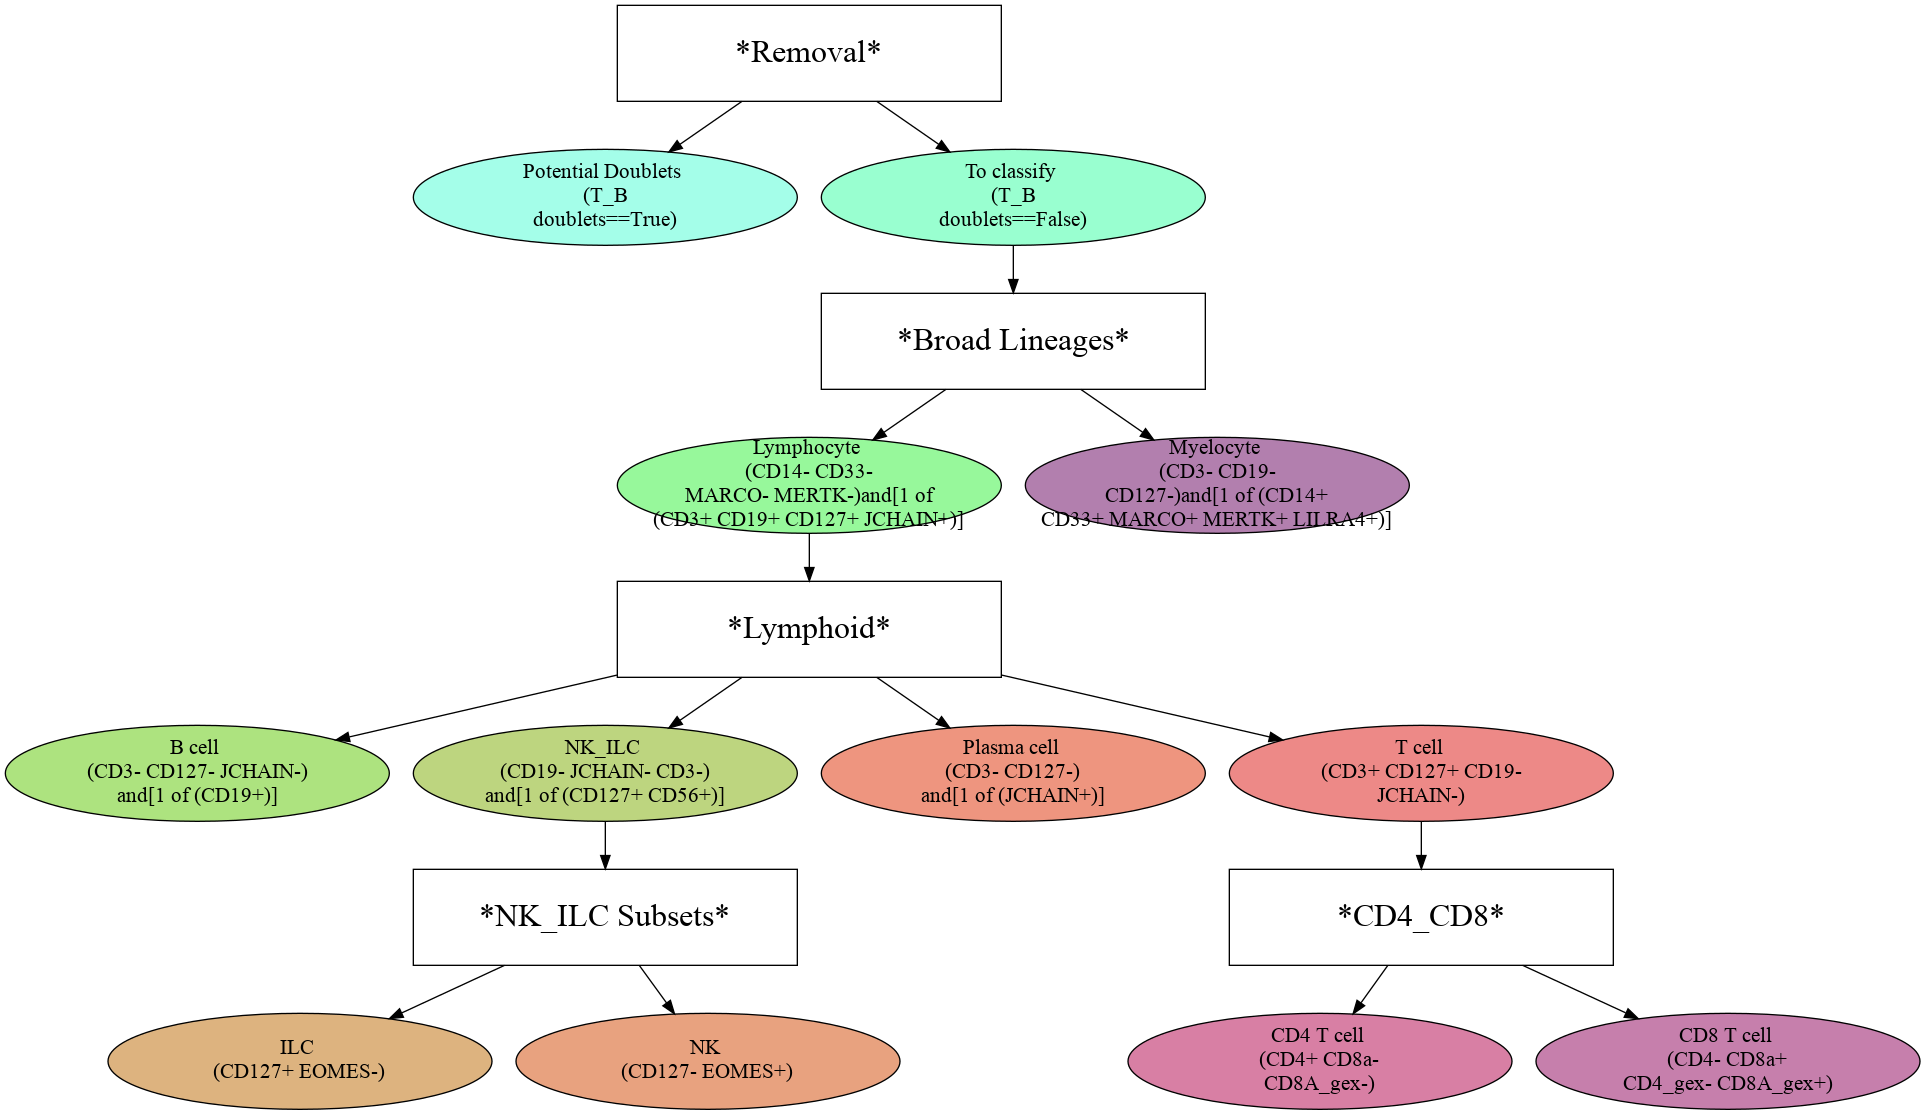

In [3]:
h = mmc.Hierarchy(load='data/IntegratedClassifier')
h.display(True)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Once the random forest classifiers have been trained and stored in the hierarchy, feature importances can be extracted as a list using `mmc.feature_importances()`, which returns a dataframe of all features sorted by importance for the specified level. Within MMoCHi, features are labeled by their modality (separated by `'_mod_'`). You can see here that for lymphocyte subsets, there are many genes whose expression is highly important for subset identification:

In [4]:
mmc.feature_importances(h, 'Lymphoid').head(25)

,Feature,Importance
0,MS4A1_mod_GEX,0.022590
1,CD38_mod_GEX,0.018933
2,FKBP11_mod_GEX,0.015617
3,MT-ND1_mod_GEX,0.014589
4,NME1_mod_GEX,0.013113
5,POU2AF1_mod_GEX,0.012418
6,TXNDC11_mod_GEX,0.011857
7,HYOU1_mod_GEX,0.010470
8,UBE2J1_mod_GEX,0.010186
9,MZB1_mod_GEX,0.010176


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;On other levels, such as CD4<sup>+</sup> vs CD8<sup>+</sup> T cells, you can see various proteins played a more important role in cell type classification. Note that the much higher values for importance here are in part due to the hyperparameters used to train the random forest at this level (see the [Integrated Classification tutorial](./Integrated_Classification.ipynb) for more details).

In [5]:
mmc.feature_importances(h, 'CD4_CD8').head(25)

,Feature,Importance
0,CD8A_mod_GEX,0.241259
1,CD8a_mod_landmark_protein,0.187784
2,CD4_mod_landmark_protein,0.145425
3,CD8B_mod_GEX,0.064885
4,CD3_mod_landmark_protein,0.052041
5,CTSW_mod_GEX,0.029946
6,CD14_mod_landmark_protein,0.028135
7,CCL5_mod_GEX,0.021405
8,NKG7_mod_GEX,0.021170
9,LINC02446_mod_GEX,0.013449


## **Visualization for validation of the Classifier**

In [6]:
(adata.obsm['lin']['Lymphoid_hc'].astype(str) + adata.obsm['lin']['Lymphoid_class'].astype(str)).value_counts()

T cellT cell              5212
nannan                    3951
?T cell                   1408
NK_ILCNK_ILC              1232
B cellB cell               734
?NK_ILC                    328
?B cell                    139
Plasma cellPlasma cell      48
?Plasma cell                37
NK_ILCT cell                15
T cellNK_ILC                 7
NK_ILCB cell                 1
dtype: int64

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The plotting function below displays the top 25 most important features for the specified classification layer(s) in violin plots. These plots highlight which subsets express the most important features. By default, these plots group events by their high confidence label and their predicted classification. This is incredibly useful for exploring discrepancies between high confidence thresholding and classification, or for understanding performance on cells that were not high confidence thresholded. For example, here we can identify that in the Lymphoid classifier, many of the events not labeled by high confidence thresholding, but labeled NK/ILC (`'? -> NK_ILC'`) actually expressed CD3 protein. Although this only represents ~200 events, it suggests there is room for improvement in the high confidence thresholding or the hierarchy design. Note that these plots also show the expression of these markers on cells not included at this classification level (`'nan -> nan'`). 

... storing 'hc -> class' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


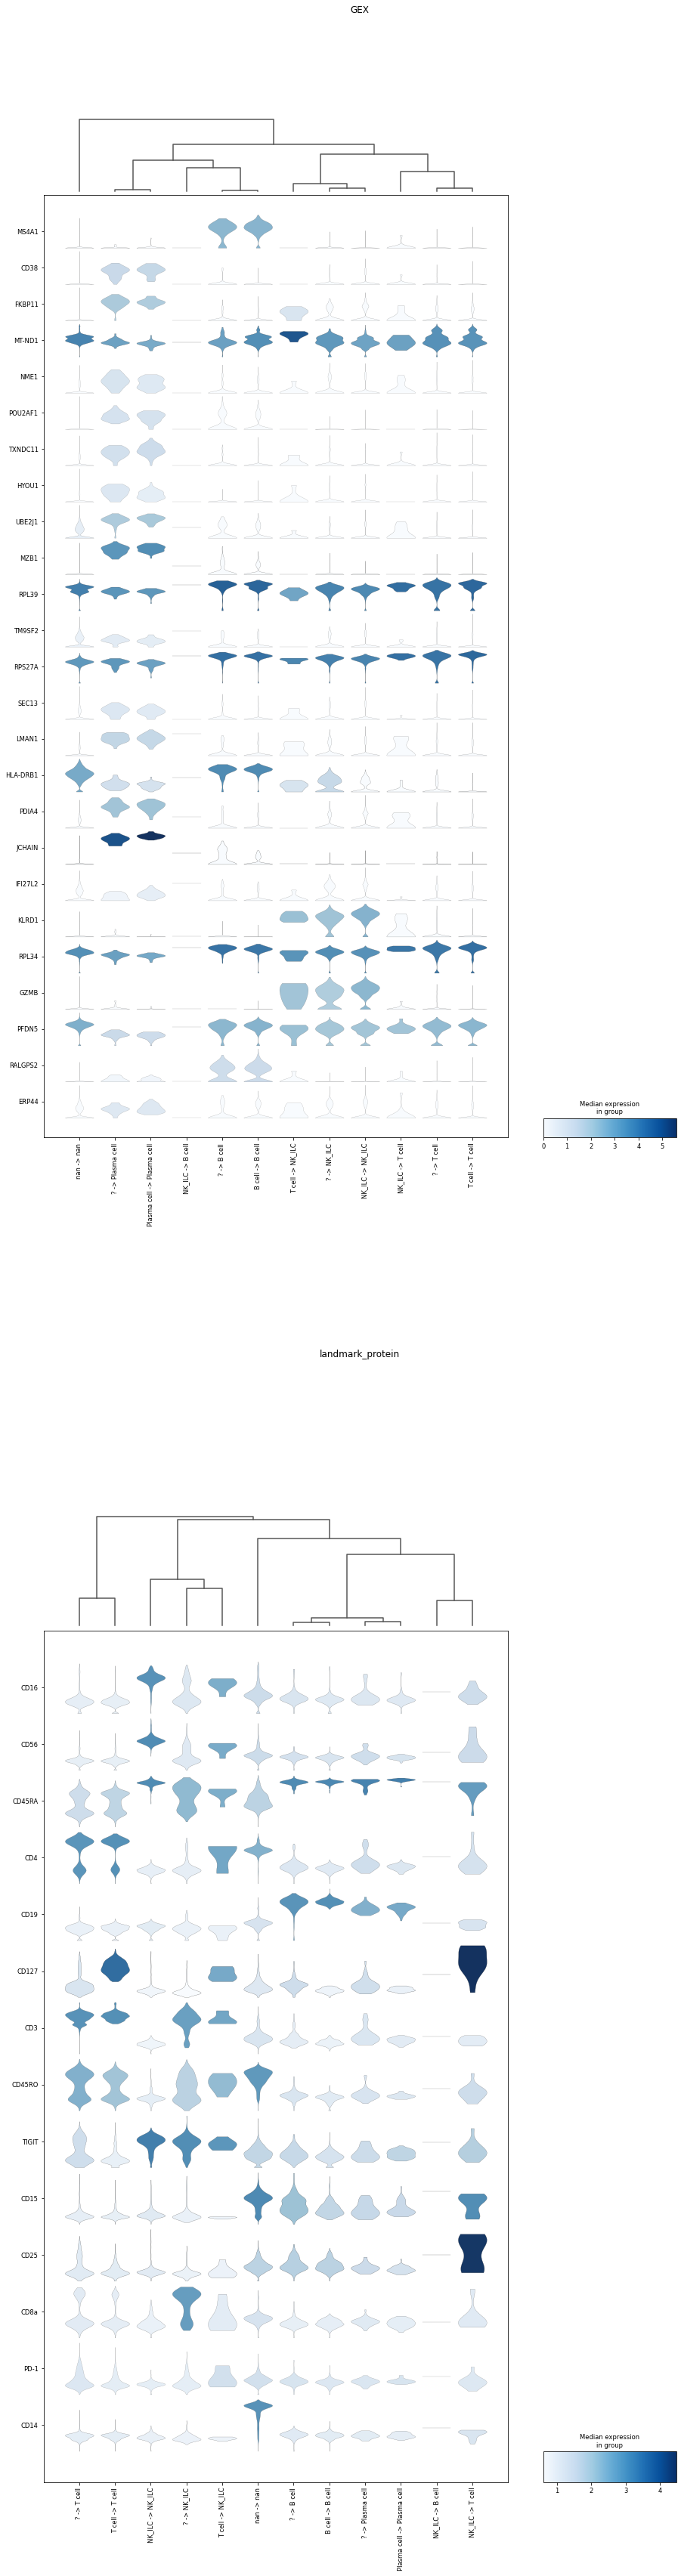

In [7]:
mmc.plot_important_features(adata, 'Lymphoid', h)

To best compare expression levels between classified subsets, 'classification' can be passed as an argument to display all subsets or the classification level(s).

         Falling back to preprocessing with `sc.pp.pca` and default params.


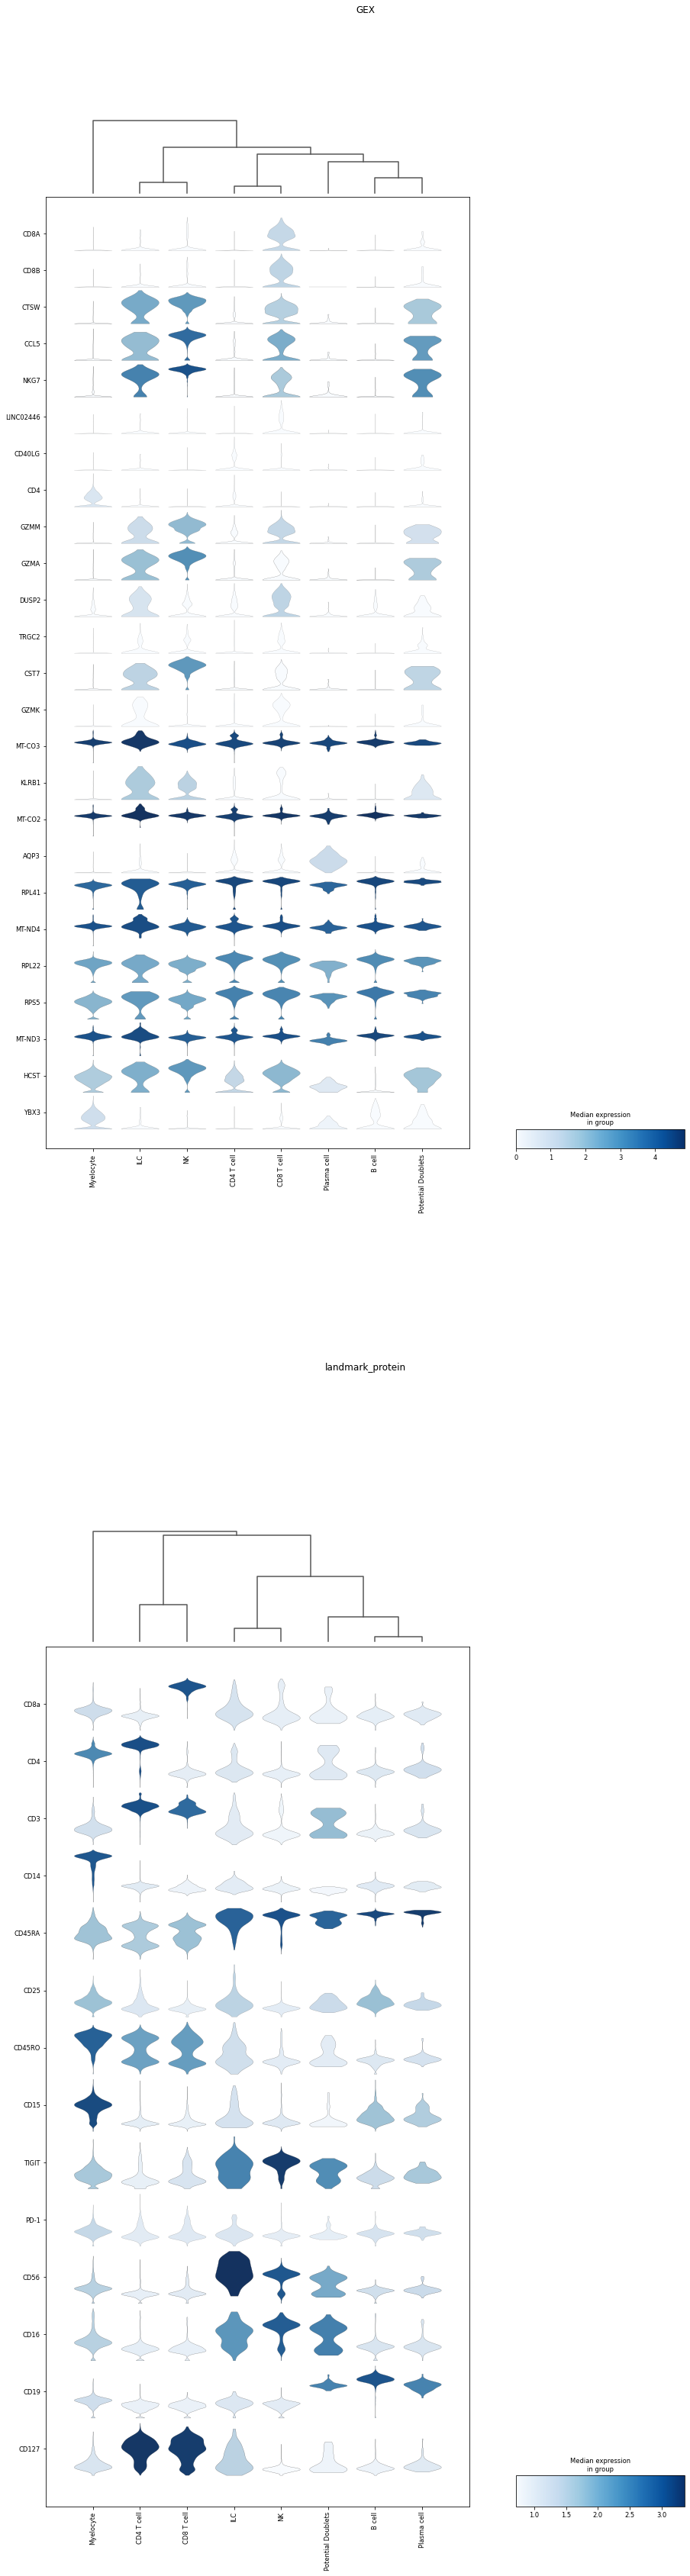

In [8]:
mmc.plot_important_features(adata, ['CD4_CD8'], h, reference = 'classification')

<div class="alert alert-success">

**Great!**
    
You can now gain more insight into the decisions your classifier makes, and use feature importances to identify cell type markers
</div>